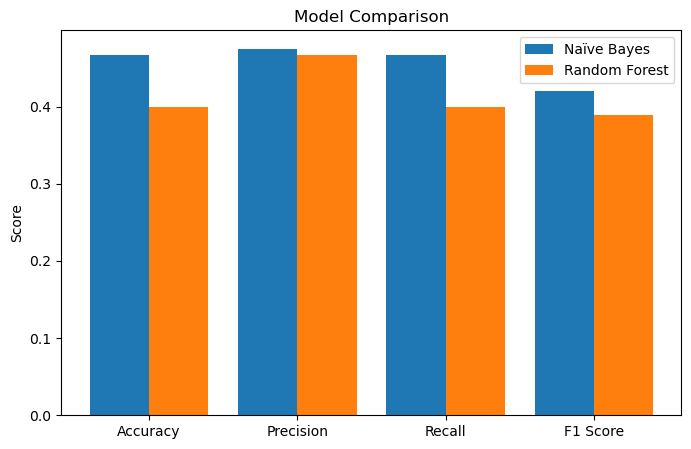

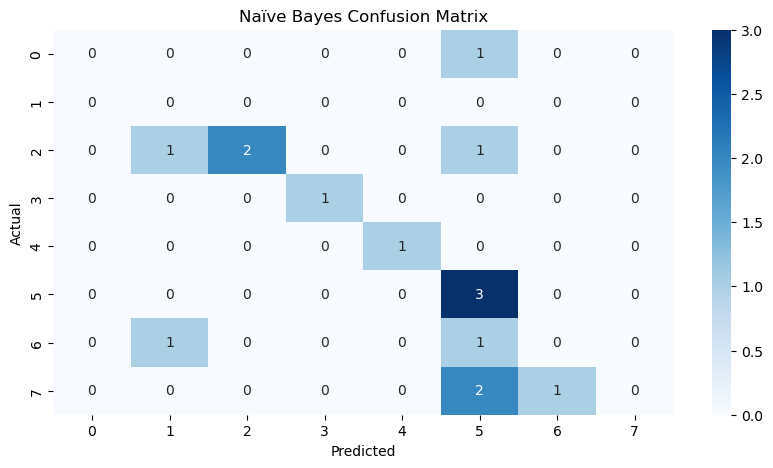

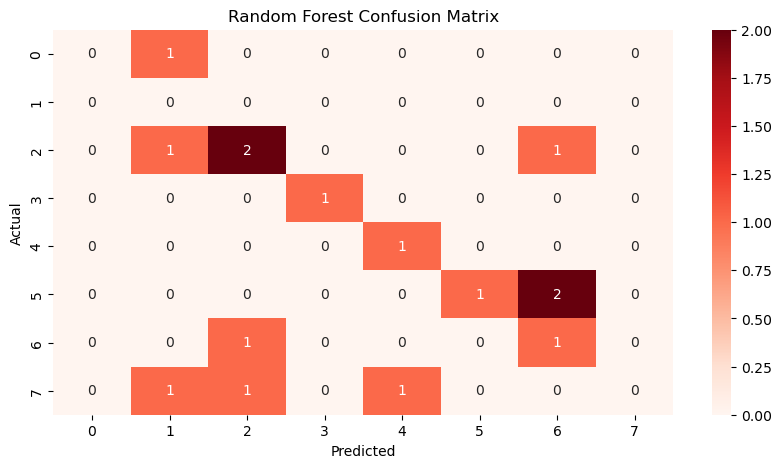


Naïve Bayes Probability Table (Top 20):
         4.0       4.1       4.2       4.3       4.4       4.5       4.6       4.7       4.8       4.9
0   0.029771  0.152433  0.116304  0.113905  0.061502  0.095188  0.171007  0.145279  0.087131  0.027479
1   0.025817  0.127673  0.096918  0.087820  0.062458  0.081910  0.329554  0.108162  0.054047  0.025641
2   0.032859  0.147016  0.116781  0.099583  0.151265  0.092256  0.140490  0.120751  0.066914  0.032084
3   0.030589  0.155005  0.121055  0.104287  0.061304  0.095277  0.160661  0.132945  0.065058  0.073819
4   0.032327  0.168786  0.113428  0.101689  0.061111  0.101912  0.170120  0.152426  0.068283  0.029918
5   0.028393  0.133557  0.127858  0.125670  0.060901  0.096932  0.191190  0.140444  0.066264  0.028792
6   0.034126  0.131059  0.122821  0.103803  0.065668  0.097341  0.156036  0.131393  0.070088  0.087666
7   0.030513  0.121945  0.112532  0.111824  0.061428  0.109080  0.147362  0.126394  0.148724  0.030200
8   0.027213  0.125443  0.245216

Enter the number of descriptions (1-3):  2
Enter description 1:  scenary
Enter description 2:  good roads
Enter the preferred month (1-12):  6



Naïve Bayes Recommendations:
            City  Rating
0     Khandala       4.6
1    Kalimpong       4.2
2     Srinagar       4.2
3  Lakshadweep       4.0
4   Coimbatore       4.2

Random Forest Recommendations:
                City  Rating
0    Visakhapatnam       4.6
1       Coimbatore       4.2
2  Ajanta and Ellora     4.7
3         Khandala       4.6
4      Vaishno Devi      4.1


In [50]:
## import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)



def preprocess_data(df):
    descriptions = df["About the city (long Description)"].fillna("")
    df["Rating"] = pd.to_numeric(df["Rating"], errors='coerce')
    df["Rating"] = df["Rating"].fillna(df["Rating"].median())
    df["Best Month"] = df["Best Time to visit"].str.extract(r'(?i)(January|February|March|April|May|June|July|August|September|October|November|December)')
    month_map = {m: i+1 for i, m in enumerate(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])}
    df["Best Month"] = df["Best Month"].map(month_map)
    return descriptions, df["Rating"], df

def train_models(descriptions, ratings):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(ratings)
    X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2, random_state=42)
    
    nb_model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), MultinomialNB())
    nb_model.fit(X_train, y_train)
    
    dt_model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), RandomForestClassifier(n_estimators=100))
    dt_model.fit(X_train, y_train)
    
    y_pred_nb = nb_model.predict(X_test)
    y_pred_dt = dt_model.predict(X_test)
    
    metrics = {
        "Accuracy": [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_dt)],
        "Precision": [precision_score(y_test, y_pred_nb, average='weighted', zero_division=0),
                      precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)],
        "Recall": [recall_score(y_test, y_pred_nb, average='weighted', zero_division=0),
                   recall_score(y_test, y_pred_dt, average='weighted', zero_division=0)],
        "F1 Score": [f1_score(y_test, y_pred_nb, average='weighted', zero_division=0),
                     f1_score(y_test, y_pred_dt, average='weighted', zero_division=0)]
    }
    
    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics))
    plt.bar(x - 0.2, [metrics[m][0] for m in metrics], 0.4, label="Naïve Bayes")
    plt.bar(x + 0.2, [metrics[m][1] for m in metrics], 0.4, label="Random Forest")
    plt.xticks(x, metrics.keys())
    plt.ylabel("Score")
    plt.title("Model Comparison")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt="d", cmap="Blues")
    plt.title("Naïve Bayes Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", cmap="Reds")
    plt.title("Random Forest Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return nb_model, dt_model, label_encoder

def recommend_cities(nb_model, dt_model, label_encoder, df):

    # Set display options for larger tables
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)  # Increase width of table
    pd.set_option('display.max_colwidth', None)  # Avoid truncating cell content

    
    # Calculate the Naïve Bayes probabilities and show the table before user input
    nb_pred = nb_model.predict_proba(df["About the city (long Description)"].fillna(""))  # Use all descriptions for the probability table
    print("\nNaïve Bayes Probability Table (Top 20):")
    print(pd.DataFrame(nb_pred, columns=label_encoder.classes_).head(20))  # Display top 20 rows of the table

        # Optionally, reset to default after you're done
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
    
    num_descriptions = int(input("Enter the number of descriptions (1-3): "))
    descriptions = [input(f"Enter description {i+1}: ") for i in range(num_descriptions)]
    month = int(input("Enter the preferred month (1-12): "))
    
    input_text = " ".join(descriptions)
    
    # Naïve Bayes predictions
    nb_pred_input = nb_model.predict_proba([input_text])
    top_indices_nb = np.argsort(nb_pred_input[0])[-10:][::-1]  # Top 10 predictions for Naïve Bayes
    sampled_indices_nb = np.random.choice(top_indices_nb, size=5, replace=False, p=nb_pred_input[0][top_indices_nb]/np.sum(nb_pred_input[0][top_indices_nb]))
    predicted_ratings_nb = label_encoder.inverse_transform(sampled_indices_nb)
    
    recommended_cities_nb = df[df["Rating"].isin(predicted_ratings_nb)][["City", "Rating"]].sample(n=5, random_state=42)
    recommended_cities_nb.reset_index(drop=True, inplace=True)  # Reset index to start from 0 (1, 2, 3,...)
    
    # Random Forest predictions
    dt_pred = dt_model.predict_proba([input_text])
    top_indices_dt = np.argsort(dt_pred[0])[-10:][::-1]  # Top 10 predictions for Random Forest
    sampled_indices_dt = np.random.choice(top_indices_dt, size=5, replace=False, p=dt_pred[0][top_indices_dt]/np.sum(dt_pred[0][top_indices_dt]))
    predicted_ratings_dt = label_encoder.inverse_transform(sampled_indices_dt)
    
    recommended_cities_dt = df[df["Rating"].isin(predicted_ratings_dt)][["City", "Rating"]].sample(n=5, random_state=42)
    recommended_cities_dt.reset_index(drop=True, inplace=True)  # Reset index to start from 0 (1, 2, 3,...)
    
    # Display recommendations with numbered rows
    print("\nNaïve Bayes Recommendations:")
    print(recommended_cities_nb.rename_axis('No.').reset_index(drop=True))  # Renaming index to 'No.'
    print("\nRandom Forest Recommendations:")
    print(recommended_cities_dt.rename_axis('No.').reset_index(drop=True))  # Renaming index to 'No.'


df = pd.read_csv("holidify.csv")
descriptions, ratings, df = preprocess_data(df)
nb_model, dt_model, label_encoder = train_models(descriptions, ratings)
recommend_cities(nb_model, dt_model, label_encoder, df)